In [1]:
import os
import sys
import re
import pdb

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

print('pwd', os.getcwd())
print('np ', np.__version__)
print('sp ', sp.__version__)

pwd /home/marko/Projects/DU/DU0
np  1.11.1
sp  0.18.1


# Symbolic demo

In [2]:
import sympy

# definicija varijabli
x0, x1, x2 = sympy.var('x0, x1, x2')

# definicija funkcija
f = sympy.Matrix([x0**2+x1*x2, x0+x1+x2])
g = sympy.Matrix([sympy.sin(x0), x1**3+x0*x1, x2])

# mapiranje funkcije g na parametre funkcije f
substitution_fg = {'x0':g[0], 'x1':g[1], 'x2':g[2]}

# kompozicija funkcija
fog = f.subs(substitution_fg)

# izravno diferenciranje
Jfog = fog.jacobian([x0,x1,x2])
Jfog.simplify()
print('Jfog')
sympy.pprint(Jfog)

print('\n\n')
# Jakobijani pojedinačnih funkcija
Jf = f.jacobian([x0,x1,x2])
Jg = g.jacobian([x0,x1,x2])

# pravilo ulančavanja
Jfog2 = Jf.subs(substitution_fg)*Jg
Jfog2.simplify()
print('Jfog2')
sympy.pprint(Jfog2)

Jfog
⎡                      ⎛         2⎞     ⎛       2⎞⎤
⎢x₁⋅x₂ + sin(2⋅x₀)  x₂⋅⎝x₀ + 3⋅x₁ ⎠  x₁⋅⎝x₀ + x₁ ⎠⎥
⎢                                                 ⎥
⎢                              2                  ⎥
⎣  x₁ + cos(x₀)       x₀ + 3⋅x₁            1      ⎦



Jfog2
⎡                      ⎛         2⎞     ⎛       2⎞⎤
⎢x₁⋅x₂ + sin(2⋅x₀)  x₂⋅⎝x₀ + 3⋅x₁ ⎠  x₁⋅⎝x₀ + x₁ ⎠⎥
⎢                                                 ⎥
⎢                              2                  ⎥
⎣  x₁ + cos(x₀)       x₀ + 3⋅x₁            1      ⎦


In [3]:
# nastavak prethodnog primjera...
f0 = sympy.Matrix([f[0]])
Jf0 = f0.jacobian([x0,x1,x2])

# Hesseova matrica je Jakobijan gradijenta:
H = Jf0.jacobian([x0,x1,x2])
sympy.pprint(H)
# eigen values
# all > 0 -> min
# all < 0 -> max
# else

⎡2  0  0⎤
⎢       ⎥
⎢0  0  1⎥
⎢       ⎥
⎣0  1  0⎦


# Labos

## data.py

In [4]:
# py2
from __future__ import division

import random
import numpy as np
import matplotlib.pyplot as plt


def _sample_uniform(lo, hi):
    return np.random.random_sample()* (hi - lo) + lo

def _rotation_matrix2D(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

class Random2DGaussian:

    def __init__(self, minx=0, maxx=10, miny=0, maxy=10):

        mu = _sample_uniform(minx, maxx), _sample_uniform(miny, maxy)
        self.mu = np.array(mu)


        eigvalx = (np.random.random_sample()*(maxx - minx)/5)**2
        eigvaly = (np.random.random_sample()*(maxy - miny)/5)**2
        D = np.diag([eigvalx, eigvaly])

        R = _rotation_matrix2D(np.random.random_sample() * 360)
        self.sigma = np.dot(R.T, np.dot(D, R))

    def get_sample(self, n_samples=1):
        return np.random.multivariate_normal(self.mu, self.sigma, n_samples)


def sample_gauss_2d(C, N):
    Gs = [Random2DGaussian() for i in range(C)]
    Y = np.random.randint(0, C, N)
    X = np.array([Gs[c].get_sample()[0] for c in Y])
    return X, Y



def confusion_mat(y_true, y_pred):
    C = sorted(set(y_true) | set(y_pred))
    n_classes = len(C)
    mat = np.zeros((n_classes, n_classes), dtype='int')
    pairs = np.vstack((y_true, y_pred)).T

    for i, c_i in enumerate(C):
        for j, c_j in enumerate(C):
            mat[i][j] = (pairs == (c_i, c_j)).all(axis=1).sum()

    return mat, C


def get_stats(bin_conf_mat):
    tn, fp, fn, tp = bin_conf_mat.flatten()

    accuracy = (tp+tn) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn
                  )
    return accuracy, recall, precision

def eval_perf_binary(Y, Y_):
    mat, classes = confusion_mat(Y_, Y)
    return get_stats(bin_conf_mat)




def twoway_confusion_matrix(mat, i):
    n_samples_i = mat[i].sum()
    n_samples = mat.sum()
    
    tp = mat[i, i]
    fp = mat[:, i].sum() - tp
    fn = n_samples_i - tp
    tn = n_samples - tp - fp - fn
    return np.array([[tp, fp], [fn, tn]])
    

def eval_perf_multi(Y, Y_):
    mat, classes = confusion_mat(Y_, Y)
    precision = []; recall = []
    
    for i in range(len(classes)):
        mat_i = twoway_confusion_matrix(mat, i)
        acc, p, r = get_stats(mat_i)
        precision.append(p); recall.append(r)
        
    
    precision = np.array(precision)
    recall = np.array(recall)
    accuracy = mat.trace() / mat.sum()
    return accuracy, mat, classes, precision, recall


def _precision(Y, i):
    clf_as_one = Y[i:]

    tp = (clf_as_one == 1).sum()
    fp = (clf_as_one == 0).sum()

    return tp / (tp + fp)

def eval_AP(Yr):
    Yr = np.array(Yr)
    n = len(Yr)

    return np.sum(_precision(Yr, i)*Yr[i] for i in range(n)) / np.sum(Yr)



def graph_data(X, Y_, Y):
    """
        Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    Y_ : 1-D array_like, of length N
        true classes
    Y: scalar value
        predicted classes
    """

    pairs = np.vstack((Y_, Y)).T
    
    
    correct = Y_ == Y
    wrong = Y_ != Y
    colors = Y_


    
    plt.scatter(X[correct, 0], X[correct, 1], marker='o', 
                c=colors[correct], edgecolor='k', cmap='gray')
    plt.scatter(X[wrong, 0], X[wrong, 1], marker='s', 
                c=colors[wrong], edgecolor='k', cmap='gray')






# binlogreg

In [5]:
import numpy as np

import data

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def cross_entropy_loss(prob, y):
    return -y * np.log(prob) - (1 - y) * np.log(1 - prob)



def binlogreg_train(X, Y_, param_niter=100000, param_delta=0.1, verbose=False):
    """
    Method that trains binary logistic regresion for given data
    and returns parameters of trained model.

    Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    Y_ : 1-D array_like, of length N
        labels for passed data

    Returns
    -------
    w : 1-D array_like, of length 2
        array of weights for each feature
    b: scalar value
        bias parameter

    """
    n_samples = len(X)
    N = 2 # number of features
    w = np.random.randn(N)
    b = 0


    for i in range(param_niter):
        scores = np.dot(X, w) + b

        # vjerojatnosti razreda c_1
        probs = sigmoid(scores)
        loss  = np.sum(cross_entropy_loss(probs, Y_))

        if verbose and i % 10 == 0:
            print("iteration {}: loss {}".format(i, loss))

        # derivacije gubitka po klasifikacijskom rezultatu
        dL_dscores = probs - Y_

        # gradijenti parametara
        grad_w = 1.0/n_samples  * np.dot(dL_dscores, X)
        grad_b = 1.0/n_samples  * np.sum(dL_dscores)

        # poboljsani parametri
        w += -param_delta * grad_w
        b += -param_delta * grad_b

    return w, b

def binlogreg_classify(X, w, b):
    '''
    Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    w : 1-D array_like, of length 2
        array of weights for each feature
    b: scalar value
        bias parameter

    Returns
    -------
    probs : 1-D array_like, of length N
        probability of class 1 for each sample in X
    '''
    return sigmoid(np.dot(X, w) + b)


if __name__=="__main__":
    np.random.seed(100)

    # get the training dataset
    X, Y_ = data.sample_gauss_2d(2, 100)

    # train the model
    w, b = binlogreg_train(X, Y_)


    # evaluate the model on the training dataset
    probs = binlogreg_classify(X, w,b)
    Y = np.array(probs > 0.5, dtype=int)

    # report performance
    accuracy, recall, precision = data.eval_perf_binary(Y, Y_)
    AP = data.eval_AP(Y_[probs.argsort()])
    print (accuracy, recall, precision, AP)


0.995 0.99 1.0 1.0


In [6]:
import data

print(data.eval_AP([0,0,0,1,1,1]))
print(data.eval_AP([0,0,1,0,1,1]))
print(data.eval_AP([0,1,0,1,0,1]))
print(data.eval_AP([1,0,1,0,1,0]))

1.0
0.916666666667
0.755555555556
0.5


In [7]:
def graph_surface(fun, rect, offset, width=250, height=250):
    '''
    fun    ... decizijska funkcija (Nx2)->(Nx1)
    rect   ... zeljena domena prikaza zadana kao:
             ([x_min,y_min], [x_max,y_max])
    offset ... "nulta" vrijednost decizijske funkcije na koju 
             je potrebno poravnati srediste palete boja;
             tipicno imamo:
             offset = 0.5 za probabilisticke modele 
                (npr. logisticka regresija)
             offset = 0 za modele koji ne spljoscuju
                klasifikacijske rezultate (npr. SVM)
    width,height ... rezolucija koordinatne mreze
    '''
    
    (x_min, y_min), (x_max, y_max) = rect
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, width), np.linspace(y_min, y_max, height))
    XX = np.c_[xx.ravel(), yy.ravel()]
    
    Z = fun(XX).reshape(xx.shape)
    
    
    
    delta = np.abs(Z-offset).max() 
    #plt.pcolormesh(xx, yy, Z, vmin=offset-delta, vmax=offset+delta)
    plt.pcolormesh(xx, yy, Z, vmin=offset-delta, vmax=offset+delta)
    plt.contour(xx, yy, Z, levels=[offset])
    

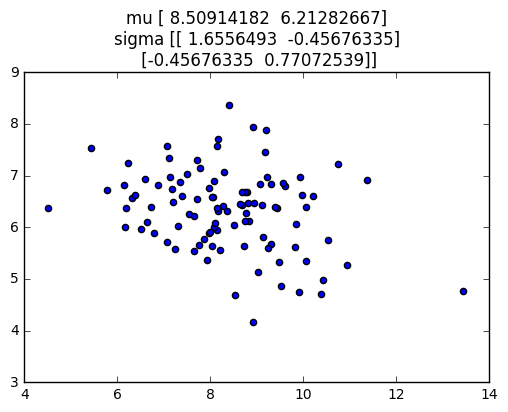

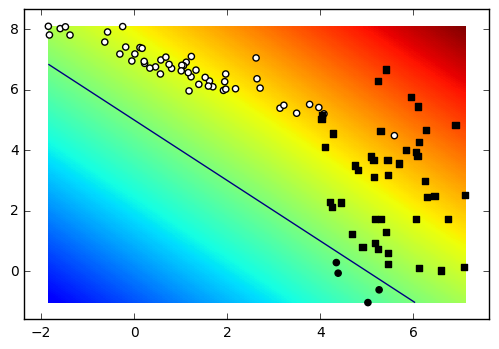

In [8]:

if __name__=="__main__":
    G = Random2DGaussian()
    X = G.get_sample(100)
    plt.scatter(X[:,0], X[:,1])

    plt.title('mu %s\nsigma %s' % (G.mu, G.sigma))
    plt.show()



    def myDummyDecision(X):
        scores = X[:,0] + X[:,1] - 5
        return scores

    np.random.seed(100)

    # get the training dataset
    X,Y_ = sample_gauss_2d(2, 100)

    # get the class predictions
    Y = myDummyDecision(X)>0

    # graph the data points
    
    bbox=(np.min(X, axis=0), np.max(X, axis=0))
    
    graph_surface(myDummyDecision, bbox, offset=0)
    graph_data(X, Y_, Y)

    # show the results
    plt.show()

In [9]:
def binlogreg_decfun(X, w,b):
    def classify(X):
        return binlogreg_classify(X, w,b)
    return classify

0.965 1.0 0.934579439252 0.998278730675


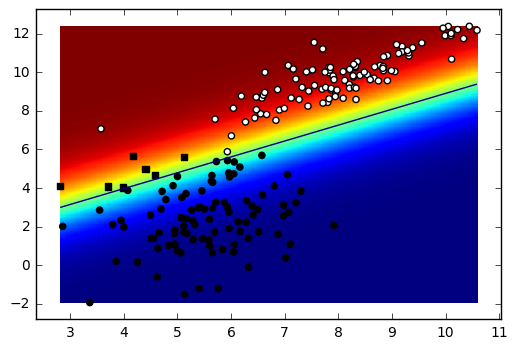

In [24]:
# instantiate the dataset
np.random.seed(100)
X, Y_ = data.sample_gauss_2d(2, 100)

# train the logistic regression model
w, b = binlogreg_train(X, Y_, param_niter=100)

# evaluate the model on the train set
probs = binlogreg_classify(X, w,b)


# recover the predicted classes Y
Y = np.array(probs > 0.5, dtype=int)

# evaluate and print performance measures
accuracy, recall, precision = data.eval_perf_binary(Y, Y_)
AP = data.eval_AP(Y_[probs.argsort()])
print (accuracy, recall, precision, AP)

# graph the decision surface
decfun = binlogreg_decfun(X, w,b)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
decfun = binlogreg_decfun(X, w,b)
graph_data(X, Y_, Y)

# show the plot
plt.show()

# Multiclass

In [25]:
import numpy as np

import data

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def logreg_train(X, Y_, param_niter=1, param_delta=0.01, verbose=False):
    """
    Method that trains logistic regresion for given data
    and returns parameters of trained model.

    Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    Y_ : 1-D array_like, of length N
        labels for passed data

    Returns
    -------
    w : 1-D array_like, of length 2
        array of weights for each feature
    b: scalar value
        bias parameter

    """    
    C = np.max(Y_) + 1
    n_samples, n_features = X.shape
    W = np.random.randn(C, n_features)
    b = np.zeros(C)


    for i in range(param_niter):
                
        # eksponencirani klasifikacijski rezultati
        scores = np.dot(X, W.T) + b    # N x C
        expscores = np.exp(scores)    # N x C
        
        # nazivnik sofmaksa
        sumexp = expscores.sum(axis=1)    # N x 1

        # logaritmirane vjerojatnosti razreda 
        probs = expscores / sumexp.reshape(-1,1)     # N x C
        correct_class_prob = probs[range(len(X)), Y_]
        
        correct_class_logprobs = -np.log(correct_class_prob)   # N*1 
        # gubitak
        loss  = correct_class_logprobs.sum()

        # dijagnostički ispis
        if verbose and i % 10 == 0:
            print("iteration {}: loss {}".format(i, loss))

        # derivacije komponenata gubitka po rezultatu
        dL_ds = probs   # N x C
        dL_ds[range(len(X)),Y_] -= 1
        
        #print('dl_ds', dL_ds.shape)

        # gradijenti parametara
        grad_W = 1.0/n_samples  * np.dot(dL_ds.T, X)   # C x D
        grad_b = 1.0/n_samples  * dL_ds.sum(axis=0)    # C x 1
        
        W += -param_delta * grad_W
        b += -param_delta * grad_b

    return W, b

def logreg_classify(X, W, b):
    '''
    Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    w : 2-D array_like, of shape (C, 2)
        array of weights for each feature
    b: 1-D array like of length C
        bias parameter

    Returns
    -------
    probs : 2-D array_like, of shape (N, C)
        probability of classes for each sample in X
    '''
    
    scores = np.dot(X, W.T) + b    # N x C
    expscores = np.exp(scores)    # N x C

    # nazivnik sofmaksa
    sumexp = expscores.sum(axis=1)    # N x 1
    return expscores / sumexp.reshape(-1,1)






iteration 0: loss 653.4444851290627
iteration 10: loss 295.6473782556082
iteration 20: loss 250.17729022933338
iteration 30: loss 210.18546490119374
iteration 40: loss 177.20047248035536
iteration 50: loss 152.30490426200822
iteration 60: loss 135.05754981719386
iteration 70: loss 123.43713480734236
iteration 80: loss 115.20887877288926
iteration 90: loss 108.89432431887204
iteration 100: loss 103.7232418126831
iteration 110: loss 99.31293364076072
iteration 120: loss 95.4599549757928
iteration 130: loss 92.04329918436203
iteration 140: loss 88.98272332769801
iteration 150: loss 86.22036099448073
iteration 160: loss 83.71201266843524
iteration 170: loss 81.42262054382452
iteration 180: loss 79.32367628680436
iteration 190: loss 77.39159647666915
iteration 200: loss 75.60662624201237
iteration 210: loss 73.95205651001996
iteration 220: loss 72.4136418610118
iteration 230: loss 70.97915474422565
iteration 240: loss 69.63803682349555
iteration 250: loss 68.38112196090381
iteration 260: lo

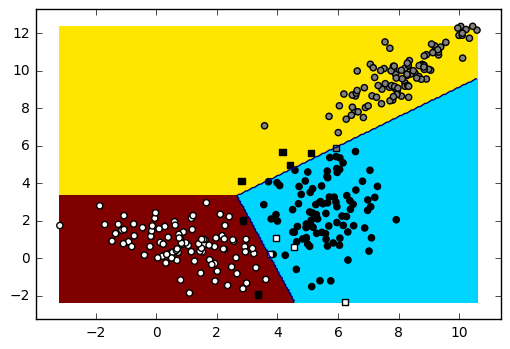

In [26]:
def logreg_decfun(X, W, b):
    def classify(X):
        return logreg_classify(X, W, b).argmax(axis=1)
    return classify

# instantiate the dataset
np.random.seed(100)
X, Y_ = data.sample_gauss_2d(3, 100)

# train the logistic regression model
W, b = logreg_train(X, Y_, param_niter=1000, param_delta=0.1, verbose=True)

# evaluate the model on the train set
probs = logreg_classify(X, W, b)
Y = np.argmax(probs, axis=1)
eval_perf_multi(Y, Y_)



# graph the decision surface
decfun = logreg_decfun(X, W, b)
bbox=(np.min(X, axis=0), np.max(X, axis=0))

graph_surface(decfun, bbox, offset=0.5)
graph_data(X, Y_, Y)

plt.show()